# Weather prediction using a recursive CNN

Libraries loading and plot size setting

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing

In [2]:
plt.rcParams['figure.figsize'] = [25, 12.5]

## Original data
Data loading from the csv file

In [3]:
weather_df = pd.read_csv("https://github.com/FraBomba6/DL_Weather_Assignment/raw/main/weather_dataset.csv")
print(weather_df.shape)
weather_df.head()

(70128, 5)


,wind_speed,wind_direction,temperature,dew_point,air_pressure
0,60,260,35,32,10185
1,60,260,36,33,10183
2,60,260,37,34,10181
3,50,260,38,35,10174
4,50,260,39,36,10169


In the following two chuncks I printed a plot to explore the data contaied in the dataset and I produce a summary of the values contained in the dataframe.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6093761d0>,
      dtype=object)

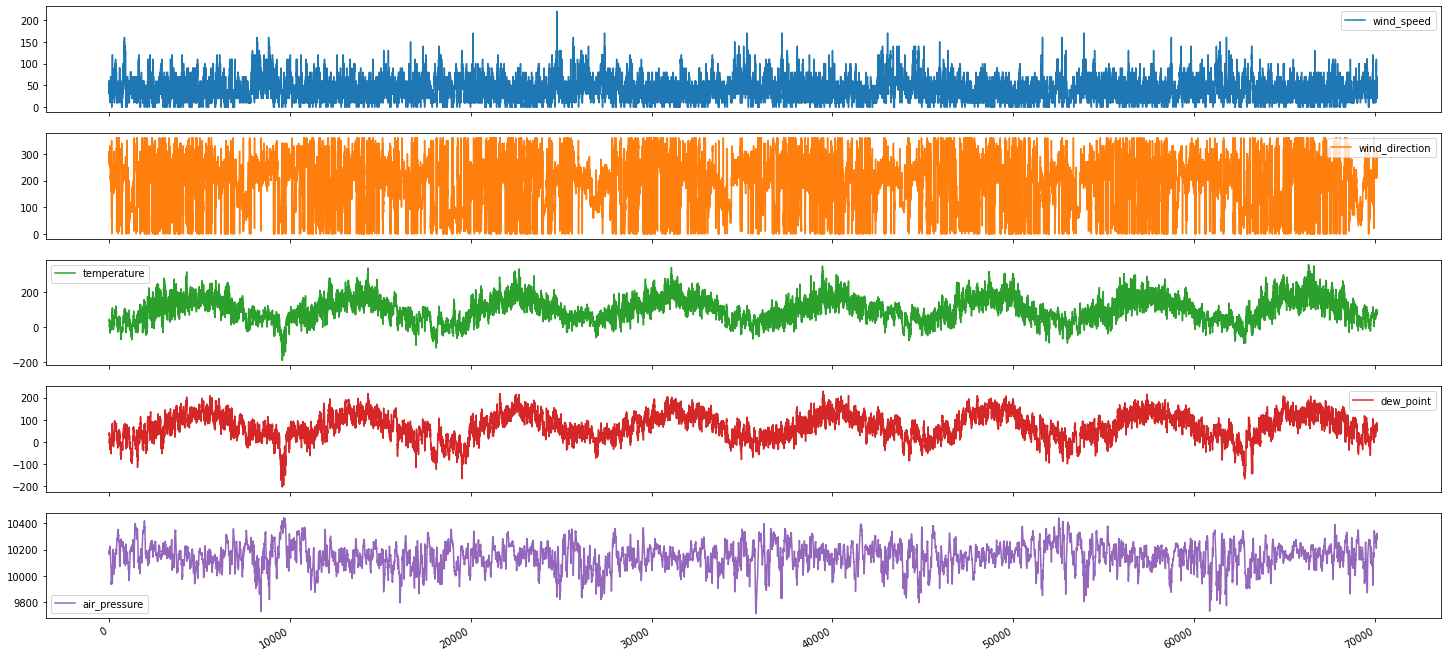

In [4]:
weather_df.plot(subplots = True)

In [5]:
weather_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wind_speed,70128.0,41.233174,23.449435,0.0,20.0,40.0,50.0,220.0
wind_direction,70128.0,186.578257,91.349559,0.0,110.0,200.0,250.0,360.0
temperature,70128.0,100.888604,67.935538,-189.0,53.0,99.0,149.0,355.0
dew_point,70128.0,70.425251,58.667802,-205.0,30.0,73.0,115.0,230.0
air_pressure,70128.0,10151.798896,96.989927,9714.0,10095.0,10157.0,10215.0,10443.0


In [6]:
weather_df.loc[weather_df["wind_speed"] == 0.0]

,wind_speed,wind_direction,temperature,dew_point,air_pressure
151,0,0,-12,-12,10077
695,0,0,-22,-22,10232
696,0,0,-20,-21,10229
721,0,0,-17,-19,10240
934,0,0,-8,-8,10240
...,...,...,...,...,...
68370,0,0,55,38,10270
68372,0,0,26,23,10276
68374,0,0,19,16,10278
69644,0,0,18,9,10243


## Data splitting
From requirements we know that the test set contains the last 168 rows of the dataset, this correspnds to the 0.24% of the dataset.

To split the remaining dataset rows into training and validation set I choose a "classic" 80/20 ratio.

In [7]:
n = weather_df.shape[0]

train_df = weather_df[0 : int(n * 0.8)]
print(train_df)
validation_df = weather_df[int(n * 0.8) : -168]
print(validation_df)
test_df = weather_df[-168 :]
print(test_df)

       wind_speed  wind_direction  temperature  dew_point  air_pressure
0              60             260           35         32         10185
1              60             260           36         33         10183
2              60             260           37         34         10181
3              50             260           38         35         10174
4              50             260           39         36         10169
...           ...             ...          ...        ...           ...
56097          30              30          208        146         10239
56098          30              80          224        145         10235
56099          30              60          230        147         10231
56100          50              50          231        145         10227
56101          50              50          231        144         10222

[56102 rows x 5 columns]
       wind_speed  wind_direction  temperature  dew_point  air_pressure
56102          50              30     

## Data Normalization
Given the information contained in the slides I used the mean normalization rather than the MinMax normalization.

Using the built-in functions of Pandas I created a DataFrame normalizer class to use with the various datasets:

In [8]:
class DataFrameNormalizer:
  def __init__(self, df: pd.DataFrame):
    self._mean = df.mean()
    self._std = df.std()
    self._min = df.min()
    self._max = df.max()

  def mean_normalization(self, df_to_normalize: pd.DataFrame):
    return (df_to_normalize - self._mean) / self._std

  def minmax_normalization(self, df_to_normalize: pd.DataFrame):
    return (df_to_normalize - self._min) / (self._max - self._min)

Then, I applied the transofrmation the tree sets using the class previously created:

In [9]:
normalizer = DataFrameNormalizer(train_df)
train_df = normalizer.mean_normalization(train_df)
validation_df = normalizer.mean_normalization(validation_df)
test_df = normalizer.mean_normalization(test_df)

print(train_df.head())
print(validation_df.head())
print(test_df.head())

   wind_speed  wind_direction  temperature  dew_point  air_pressure
0    0.777143        0.805403    -0.940762  -0.620012      0.324448
1    0.777143        0.805403    -0.925750  -0.602795      0.303998
2    0.777143        0.805403    -0.910737  -0.585578      0.283548
3    0.355617        0.805403    -0.895725  -0.568361      0.211975
4    0.355617        0.805403    -0.880713  -0.551144      0.160851
       wind_speed  wind_direction  temperature  dew_point  air_pressure
56102    0.355617       -1.715013     1.956565   1.377145      0.672091
56103    0.355617       -1.715013     1.881505   1.325494      0.641416
56104   -0.065909       -1.605430     1.836469   1.308277      0.600517
56105   -0.065909       -1.605430     1.701360   1.325494      0.600517
56106   -0.065909       -1.495847     1.461167   1.118892      0.569843
       wind_speed  wind_direction  temperature  dew_point  air_pressure
69960   -0.487435        0.695819    -0.790641  -0.757746      1.858167
69961   -0.48743

I printed the tables descriptions to make sure everything was ok:

In [10]:
print(train_df.describe().transpose())
print(validation_df.describe().transpose())
print(test_df.describe().transpose())

                  count          mean  std  ...       50%       75%       max
wind_speed      56102.0  3.586071e-16  1.0  ... -0.065909  0.355617  7.521558
wind_direction  56102.0  1.044301e-15  1.0  ...  0.147903  0.695819  1.901236
temperature     56102.0  7.102166e-16  1.0  ... -0.040038  0.710565  3.727988
dew_point       56102.0 -1.857074e-16  1.0  ... -0.000204  0.774555  2.788928
air_pressure    56102.0 -8.350277e-15  1.0  ...  0.048378  0.651641  2.962444

[5 rows x 8 columns]
                  count      mean       std  ...       50%       75%       max
wind_speed      13858.0 -0.071110  0.940094  ... -0.065909  0.355617  4.992403
wind_direction  13858.0 -0.003812  1.008249  ...  0.257486  0.695819  1.901236
temperature     13858.0  0.250037  1.077732  ...  0.305239  1.025818  3.863096
dew_point       13858.0  0.213039  1.037395  ...  0.413000  0.998374  2.547892
air_pressure    13858.0 -0.092749  0.947114  ...  0.007479  0.549393  2.430755

[5 rows x 8 columns]
              

In the first table above you could spot that the mean is not precisely 0 but a really small number near to 0. This comes from issues in floating point arithmetic.

## CNN Model and data windowing

In [ ]:
model = models.Sequential()
model.add(layers.Conv1D(32, 5, padding="same", activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(33, 5, padding="same", activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(1))

In [ ]:
class WindowManager:
  def __init__(self, input_width, label_width, shift, trn_df, val_df, tst_df):
    self._train_df = trn_df
    self._validation_df = val_df
    self._test_df = tst_df
    self._input_width = input_width
    self._label_width = label_width
    self._shift = shift

    self._window_size = None
    self._input_slice = None
    self._input_indices = None
    self._label_start = None
    self._label_slice = None
    self._label_indices = None

    self.generate_window()

  @property
  def window_size(self):
    return self._window_size

  def generate_window(self, input_width = None, shift = None, label_width = None):
    if input_width is not None:
      self._input_width = input_width
    if shift is not None:
      self._shift = shift
    if label_width is not None:
      self._label_width = label_width

    self._window_size = self._input_width + self._shift
    self._input_slice = slice(0, self._input_width)
    self._input_indices = np.arange(self._window_size)[self._input_slice]

    self._label_start = self._window_size - self._label_width
    self._label_slice = slice(self._label_start, None)
    self._label_indices = np.arange(self._window_size)[self._label_slice]

  def split_window(self, features):
    inputs = features[:, self._input_slice, :]
    labels = features[:, self._label_slice, :]
    labels = tf.stack(labels[:, :, 3], axis=-1)

    inputs.set_shape([None, self._input_width, None])
    labels.set_shape([None, self._label_width, None])

    return inputs, labels

  def make_dataset_from_dataframe(self, data):
    data = np.array(data , dtype=np.float32)
    dataset = preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self._window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32
    )

    dataset = dataset.map(self.split_window)

    return dataset

  def generate_data(self):
    return \
      self.make_dataset_from_dataframe(self._train_df), \
      self.make_dataset_from_dataframe(self._validation_df), \
      self.make_dataset_from_dataframe(self._test_df)

### Preparing data

In [ ]:
windowManager = WindowManager(168, 24, 1, train_df, validation_df, test_df)
train_ds, validation_ds, test_ds = windowManager.generate_data()

## Model compiling and training

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val__loss', patience=5, mode='min')

model.compile(
  loss=tf.losses.MeanSquareError(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=[tf.metrics.MeanAbsoluteError()]
)

history = model.fit(train_ds, epochs=100, validation_data=validation_ds, callbacks=[early_stopping])